# Model Training

### Imports

In [1]:
# Imports
import os
import pandas as pd
import numpy as np
# from functions import *

# Paths
save_data = '../data'
data_path_train = os.path.join(save_data, 'train.csv')
data_path_test = os.path.join(save_data, 'test.csv')

save_images = '../images'
save_model = '../model'

if os.path.exists(save_data):
  print('Data: Save point initialized.')
if os.path.exists(data_path_train):
  print(f'Train loaded')
if os.path.exists(data_path_test):
  print(f'Test loaded\n')

if os.path.exists(save_images):
  print('Images: Save point initialized.')
if os.path.exists(save_model):
  print('Model: Save point initialized.')

Data: Save point initialized.
Train loaded
Test loaded

Images: Save point initialized.
Model: Save point initialized.


In [2]:
# More imports
import torch
import gc
import pickle
from tqdm.auto import tqdm

from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from datasets import Dataset

import gc
gc.collect()
torch.cuda.empty_cache()

### Data

In [3]:
# Load Data
df_train = pd.read_csv(data_path_train)
df_test = pd.read_csv(data_path_test)

df_train.shape, df_test.shape

((9590, 4), (2398, 4))

In [4]:
# Convert to HuggingFace Datasets
train = Dataset.from_pandas(df_train)
test = Dataset.from_pandas(df_test)

train, test

(Dataset({
     features: ['text', 'label', 'words', 'word_count'],
     num_rows: 9590
 }),
 Dataset({
     features: ['text', 'label', 'words', 'word_count'],
     num_rows: 2398
 }))

### Model

In [5]:
# Load Model
model_name = "FacebookAI/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=3,
                                                           device_map={"": 0})
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Get model device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n=== === === Model loaded on: {device} === === ===\n")

if tokenizer.pad_token is None:
  tokenizer.pad_token = tokenizer.eos_token

model.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== === === Model loaded on: cuda === === ===



RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [6]:
# Tokenize
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding="max_length", 
                     truncation=True)

# Tokenize the dataset
train = train.map(tokenize_function, batched=True)
test = test.map(tokenize_function, batched=True)

# Convert labels to torch tensors
train.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/9590 [00:00<?, ? examples/s]

Map:   0%|          | 0/2398 [00:00<?, ? examples/s]

### Training

Evaluate

In [7]:
# Custom Metrics
import evaluate
from scipy.special import softmax
from scipy.stats import entropy
from sklearn.metrics import log_loss

# Load evaluation metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

# Function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = softmax(logits, axis=-1)  # logits to probs
    predictions = np.argmax(probs, axis=-1)  # Get class preds

    labels_one_hot = np.eye(probs.shape[-1])[labels]  # kl divergence requires one-hot labels
    kl_divs = [entropy(labels_one_hot[i], probs[i]) for i in range(len(labels))]

    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1": f1.compute(predictions=predictions, references=labels, average="weighted")["f1"],
        "cross_entropy": log_loss(labels, probs),
        "kl_divergence": np.mean(kl_divs)  # Average KL-Divergence across all samples
    }

Train

In [8]:
gc.collect()
torch.cuda.empty_cache()

model_path = os.path.join(save_model, 'roberta-classifier-bias-base_2')

In [ ]:
training_args = TrainingArguments(
  output_dir=model_path,
  do_train=True,
  do_eval=True,
  do_predict=True,
  
  eval_strategy="steps",
  eval_steps=150,
  eval_accumulation_steps=4,
  
  logging_strategy="steps",
  logging_steps=300,
  
  save_strategy="steps",
  save_steps=300,
  num_train_epochs=4,
  
  learning_rate=2e-5,
  lr_scheduler_type="linear",
  warmup_ratio=0.1,
  weight_decay=0.01,
  
  load_best_model_at_end=True,
  metric_for_best_model="f1",
  greater_is_better=True,
  
  report_to="tensorboard",
  resume_from_checkpoint=True,
  
  per_device_eval_batch_size=8,
  per_device_train_batch_size=8,
  gradient_accumulation_steps=4,
  gradient_checkpointing=True
)

In [10]:
trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=train,
  eval_dataset=test,
  compute_metrics=compute_metrics
)

trainer.train()

  0%|          | 0/300 [00:00<?, ?it/s]

{'loss': 1.0174, 'grad_norm': 4.5947585105896, 'learning_rate': 1.9981033287370443e-05, 'epoch': 0.67}


  0%|          | 0/150 [00:00<?, ?it/s]

{'eval_loss': 0.7296413779258728, 'eval_accuracy': 0.6688907422852377, 'eval_f1': 0.6600237012425128, 'eval_cross_entropy': 0.729641360750356, 'eval_kl_divergence': 0.7296413508592966, 'eval_runtime': 40.654, 'eval_samples_per_second': 58.986, 'eval_steps_per_second': 3.69, 'epoch': 0.67}
{'loss': 0.5273, 'grad_norm': 16.698848724365234, 'learning_rate': 1.7790805745256703e-05, 'epoch': 1.33}


  0%|          | 0/150 [00:00<?, ?it/s]

{'eval_loss': 0.42205193638801575, 'eval_accuracy': 0.8452877397831526, 'eval_f1': 0.8446352791227741, 'eval_cross_entropy': 0.4220519314870162, 'eval_kl_divergence': 0.42205192494395594, 'eval_runtime': 40.6077, 'eval_samples_per_second': 59.053, 'eval_steps_per_second': 3.694, 'epoch': 1.33}
{'loss': 0.3942, 'grad_norm': 5.468806266784668, 'learning_rate': 1.2736629900720832e-05, 'epoch': 2.0}


  0%|          | 0/150 [00:00<?, ?it/s]

{'eval_loss': 0.35165300965309143, 'eval_accuracy': 0.8678065054211843, 'eval_f1': 0.869454293503081, 'eval_cross_entropy': 0.3516530143462602, 'eval_kl_divergence': 0.35165300754594797, 'eval_runtime': 40.7861, 'eval_samples_per_second': 58.795, 'eval_steps_per_second': 3.678, 'epoch': 2.0}
{'loss': 0.29, 'grad_norm': 7.036703586578369, 'learning_rate': 6.6764520052034054e-06, 'epoch': 2.67}


  0%|          | 0/150 [00:00<?, ?it/s]

{'eval_loss': 0.2852950692176819, 'eval_accuracy': 0.8982485404503753, 'eval_f1': 0.8985811027114035, 'eval_cross_entropy': 0.28529505989034776, 'eval_kl_divergence': 0.2852950545671637, 'eval_runtime': 40.6214, 'eval_samples_per_second': 59.033, 'eval_steps_per_second': 3.693, 'epoch': 2.67}
{'loss': 0.2618, 'grad_norm': 9.259366989135742, 'learning_rate': 1.8380308764377841e-06, 'epoch': 3.33}


  0%|          | 0/150 [00:00<?, ?it/s]

{'eval_loss': 0.29120320081710815, 'eval_accuracy': 0.8974145120934112, 'eval_f1': 0.8982084686136087, 'eval_cross_entropy': 0.29120320264016164, 'eval_kl_divergence': 0.2912031970252342, 'eval_runtime': 40.601, 'eval_samples_per_second': 59.063, 'eval_steps_per_second': 3.694, 'epoch': 3.33}
{'loss': 0.2241, 'grad_norm': 14.568239212036133, 'learning_rate': 0.0, 'epoch': 4.0}


  0%|          | 0/150 [00:00<?, ?it/s]

{'eval_loss': 0.27748119831085205, 'eval_accuracy': 0.9020016680567139, 'eval_f1': 0.9024745205988283, 'eval_cross_entropy': 0.27748119838571667, 'eval_kl_divergence': 0.27748119154488343, 'eval_runtime': 40.6624, 'eval_samples_per_second': 58.973, 'eval_steps_per_second': 3.689, 'epoch': 4.0}
{'train_runtime': 2903.177, 'train_samples_per_second': 13.213, 'train_steps_per_second': 0.103, 'train_loss': 0.4524563789367676, 'epoch': 4.0}


TrainOutput(global_step=300, training_loss=0.4524563789367676, metrics={'train_runtime': 2903.177, 'train_samples_per_second': 13.213, 'train_steps_per_second': 0.103, 'total_flos': 1.009303070404608e+16, 'train_loss': 0.4524563789367676, 'epoch': 4.0})

In [11]:
trainer.save_model(os.path.join(model_path, 
                                'roberta-political-bias-classifier_v2'))
tokenizer.save_pretrained(os.path.join(model_path,
                                       'roberta-political-bias-classifier_v2'))

('../model\\roberta-classifier-bias-base_2\\roberta-political-bias-classifier_v2\\tokenizer_config.json',
 '../model\\roberta-classifier-bias-base_2\\roberta-political-bias-classifier_v2\\special_tokens_map.json',
 '../model\\roberta-classifier-bias-base_2\\roberta-political-bias-classifier_v2\\vocab.json',
 '../model\\roberta-classifier-bias-base_2\\roberta-political-bias-classifier_v2\\merges.txt',
 '../model\\roberta-classifier-bias-base_2\\roberta-political-bias-classifier_v2\\added_tokens.json',
 '../model\\roberta-classifier-bias-base_2\\roberta-political-bias-classifier_v2\\tokenizer.json')

### Model Training Summary

In [12]:
eval_results = trainer.evaluate()
model_performance = pd.DataFrame(eval_results, index=["Value"]).T
model_performance.index.name = "Metric"
model_performance = model_performance.round(4)

print(model_performance.to_markdown())

  0%|          | 0/150 [00:00<?, ?it/s]

| Metric                  |   Value |
|:------------------------|--------:|
| eval_loss               |  0.2775 |
| eval_accuracy           |  0.902  |
| eval_f1                 |  0.9025 |
| eval_cross_entropy      |  0.2775 |
| eval_kl_divergence      |  0.2775 |
| eval_runtime            | 40.7549 |
| eval_samples_per_second | 58.839  |
| eval_steps_per_second   |  3.681  |
| epoch                   |  4      |


In [2]:
# Train
training_metrics = [
   {'loss': 1.0174, 'grad_norm': 4.5947585105896, 'learning_rate': 1.9981033287370443e-05, 'epoch': 0.67},
   {'loss': 0.5273, 'grad_norm': 16.698848724365234, 'learning_rate': 1.7790805745256703e-05, 'epoch': 1.33},
   {'loss': 0.3942, 'grad_norm': 5.468806266784668, 'learning_rate': 1.2736629900720832e-05, 'epoch': 2.0},
   {'loss': 0.29, 'grad_norm': 7.036703586578369, 'learning_rate': 6.6764520052034054e-06, 'epoch': 2.67},
   {'loss': 0.2356, 'grad_norm': 7.604381561279297, 'learning_rate': 4.166666666666667e-06, 'epoch': 3.33},
   {'loss': 0.2618, 'grad_norm': 9.259366989135742, 'learning_rate': 1.8380308764377841e-06, 'epoch': 3.33},
   {'loss': 0.2241, 'grad_norm': 14.568239212036133, 'learning_rate': 0.0, 'epoch': 4.0},  
]

# Convert to DataFrame
training_metrics = pd.DataFrame(training_metrics)

training_metrics

,loss,grad_norm,learning_rate,epoch
0,1.0174,4.594759,0.000020,0.67
1,0.5273,16.698849,0.000018,1.33
2,0.3942,5.468806,0.000013,2.00
3,0.2900,7.036704,0.000007,2.67
4,0.2356,7.604382,0.000004,3.33
5,0.2618,9.259367,0.000002,3.33
6,0.2241,14.568239,0.000000,4.00


In [3]:
# Eval
eval_metrics = [
    {'eval_loss': 0.7296413779258728, 'eval_accuracy': 0.6688907422852377, 'eval_f1': 0.6600237012425128, 'eval_cross_entropy': 0.729641360750356, 'eval_kl_divergence': 0.7296413508592966, 'eval_runtime': 40.654, 'eval_samples_per_second': 58.986, 'eval_steps_per_second': 3.69, 'epoch': 0.67},
    {'eval_loss': 0.42205193638801575, 'eval_accuracy': 0.8452877397831526, 'eval_f1': 0.8446352791227741, 'eval_cross_entropy': 0.4220519314870162, 'eval_kl_divergence': 0.42205192494395594, 'eval_runtime': 40.6077, 'eval_samples_per_second': 59.053, 'eval_steps_per_second': 3.694, 'epoch': 1.33},
    {'eval_loss': 0.35165300965309143, 'eval_accuracy': 0.8678065054211843, 'eval_f1': 0.869454293503081, 'eval_cross_entropy': 0.3516530143462602, 'eval_kl_divergence': 0.35165300754594797, 'eval_runtime': 40.7861, 'eval_samples_per_second': 58.795, 'eval_steps_per_second': 3.678, 'epoch': 2.0},
    {'eval_loss': 0.2852950692176819, 'eval_accuracy': 0.8982485404503753, 'eval_f1': 0.8985811027114035, 'eval_cross_entropy': 0.28529505989034776, 'eval_kl_divergence': 0.2852950545671637, 'eval_runtime': 40.6214, 'eval_samples_per_second': 59.033, 'eval_steps_per_second': 3.693, 'epoch': 2.67},
    {'eval_loss': 0.29120320081710815, 'eval_accuracy': 0.8974145120934112, 'eval_f1': 0.8982084686136087, 'eval_cross_entropy': 0.29120320264016164, 'eval_kl_divergence': 0.2912031970252342, 'eval_runtime': 40.601, 'eval_samples_per_second': 59.063, 'eval_steps_per_second': 3.694, 'epoch': 3.33},
    {'eval_loss': 0.27748119831085205, 'eval_accuracy': 0.9020016680567139, 'eval_f1': 0.9024745205988283, 'eval_cross_entropy': 0.27748119838571667, 'eval_kl_divergence': 0.27748119154488343, 'eval_runtime': 40.6624, 'eval_samples_per_second': 58.973, 'eval_steps_per_second': 3.689, 'epoch': 4.0}
]

# Convert to DataFrame
eval_metrics = pd.DataFrame(eval_metrics)

eval_metrics

,eval_loss,eval_accuracy,eval_f1,eval_cross_entropy,eval_kl_divergence,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.729641,0.668891,0.660024,0.729641,0.729641,40.6540,58.986,3.690,0.67
1,0.422052,0.845288,0.844635,0.422052,0.422052,40.6077,59.053,3.694,1.33
2,0.351653,0.867807,0.869454,0.351653,0.351653,40.7861,58.795,3.678,2.00
3,0.285295,0.898249,0.898581,0.285295,0.285295,40.6214,59.033,3.693,2.67
4,0.291203,0.897415,0.898208,0.291203,0.291203,40.6010,59.063,3.694,3.33
5,0.277481,0.902002,0.902475,0.277481,0.277481,40.6624,58.973,3.689,4.00


In [4]:
# Saving
eval_path = os.path.join(save_data, 'eval/v2')

if not os.path.exists(eval_path):
  os.makedirs(eval_path)
else:
  print('Eval path exists')

In [5]:
training_metrics.to_csv(os.path.join(eval_path, 'v2_training_metrics.csv'), index=False)

eval_metrics.to_csv(os.path.join(eval_path, 'v2_eval_metrics.csv'), index=False)

if os.path.exists(os.path.join(eval_path, 'v2_training_metrics.csv')):
  print('Training metrics saved')
if os.path.exists(os.path.join(eval_path, 'v2_eval_metrics.csv')):
  print('Eval metrics saved')

Training metrics saved
Eval metrics saved


#### Visuals

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
ev

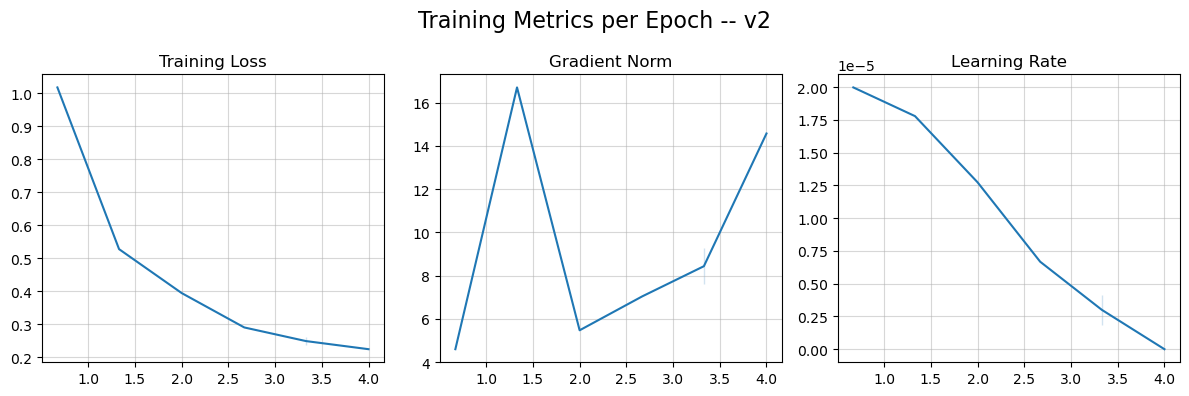

In [8]:
# Plot Training Metrics
fig, axs = plt.subplots(1, 3, figsize=(12,4))

# Loss
sns.lineplot(x="epoch", 
             y="loss", 
             data=training_metrics, 
             ax=axs[0])
axs[0].set_title("Training Loss")
axs[0].set_xlabel(None)
axs[0].set_ylabel(None)
axs[0].grid(alpha=0.5)

# Grad Norm
sns.lineplot(x="epoch", 
             y="grad_norm", 
             data=training_metrics, 
             ax=axs[1])
axs[1].set_title("Gradient Norm")
axs[1].set_xlabel(None)
axs[1].set_ylabel(None)
axs[1].grid(alpha=0.5)

# Learning Rate
sns.lineplot(x="epoch", 
             y="learning_rate", 
             data=training_metrics, 
             ax=axs[2])
axs[2].set_title("Learning Rate")
axs[2].set_xlabel(None)
axs[2].set_ylabel(None)
axs[2].grid(alpha=0.5)

fig.suptitle("Training Metrics per Epoch -- v2", 
             fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(save_images, 'v2_training_metrics.png'))
plt.show()

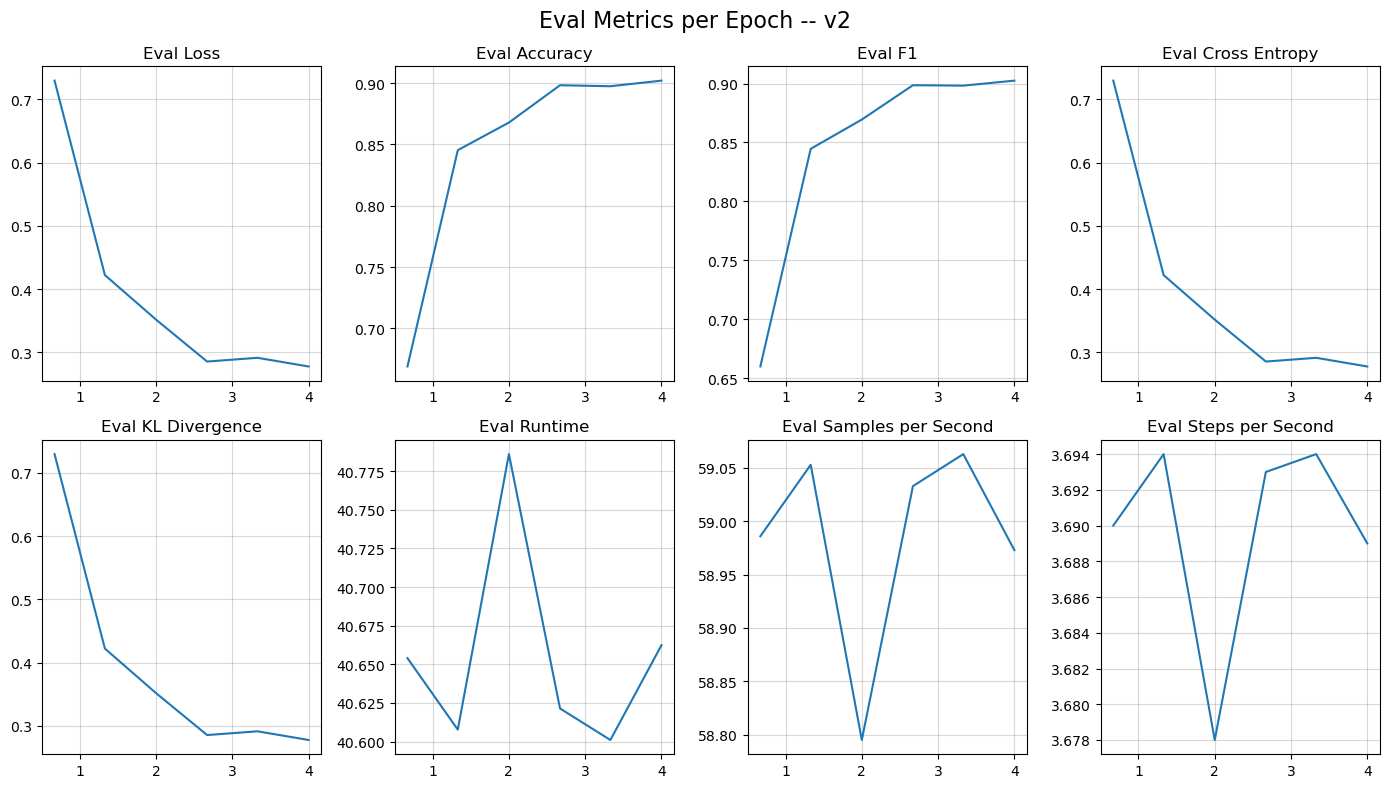

In [9]:
# Plot Eval Metrics
fig, axs = plt.subplots(2, 4, figsize=(14,8))

# Eval Loss
sns.lineplot(x="epoch", 
       y="eval_loss", 
       data=eval_metrics, 
       ax=axs[0, 0])
axs[0, 0].set_title("Eval Loss")
axs[0, 0].set_xlabel(None)
axs[0, 0].set_ylabel(None)
axs[0, 0].grid(alpha=0.5)

# Eval Accuracy
sns.lineplot(x="epoch", 
       y="eval_accuracy", 
       data=eval_metrics, 
       ax=axs[0, 1])
axs[0, 1].set_title("Eval Accuracy")
axs[0, 1].set_xlabel(None)
axs[0, 1].set_ylabel(None)
axs[0, 1].grid(alpha=0.5)

# Eval F1
sns.lineplot(x="epoch", 
       y="eval_f1", 
       data=eval_metrics, 
       ax=axs[0, 2])
axs[0, 2].set_title("Eval F1")
axs[0, 2].set_xlabel(None)
axs[0, 2].set_ylabel(None)
axs[0, 2].grid(alpha=0.5)

# Eval Cross Entropy
sns.lineplot(x="epoch", 
       y="eval_cross_entropy", 
       data=eval_metrics, 
       ax=axs[0, 3])
axs[0, 3].set_title("Eval Cross Entropy")
axs[0, 3].set_xlabel(None)
axs[0, 3].set_ylabel(None)
axs[0, 3].grid(alpha=0.5)

# Eval KL Divergence
sns.lineplot(x="epoch", 
  y="eval_kl_divergence", 
  data=eval_metrics, 
  ax=axs[1, 0])
axs[1, 0].set_title("Eval KL Divergence")
axs[1, 0].set_xlabel(None)
axs[1, 0].set_ylabel(None)
axs[1, 0].grid(alpha=0.5)

# Eval Runtime
sns.lineplot(x="epoch", 
  y="eval_runtime", 
  data=eval_metrics, 
  ax=axs[1, 1])
axs[1, 1].set_title("Eval Runtime")
axs[1, 1].set_xlabel(None)
axs[1, 1].set_ylabel(None)
axs[1, 1].grid(alpha=0.5)

# Eval Samples per Second
sns.lineplot(x="epoch", 
  y="eval_samples_per_second", 
  data=eval_metrics, 
  ax=axs[1, 2])
axs[1, 2].set_title("Eval Samples per Second")
axs[1, 2].set_xlabel(None)
axs[1, 2].set_ylabel(None)
axs[1, 2].grid(alpha=0.5)

# Eval Steps per Second
sns.lineplot(x="epoch", 
  y="eval_steps_per_second", 
  data=eval_metrics, 
  ax=axs[1, 3])
axs[1, 3].set_title("Eval Steps per Second")
axs[1, 3].set_xlabel(None)
axs[1, 3].set_ylabel(None)
axs[1, 3].grid(alpha=0.5)

fig.suptitle("Eval Metrics per Epoch -- v2", fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(save_images, 'v2_eval_metrics.png'))
plt.show()
